# YouTube trending videos

## Notebook dodatkowy z niefiltrowanymi danymi

In [34]:
# import sys
# sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')

from numpy import nan
%matplotlib inline
import random
import xgboost as xgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import recall_score, f1_score, precision_score, plot_roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from helpers.files import load_csv

plt.rcParams["figure.facecolor"] = "#a9a9a9"
random.seed(0)
np.random.seed(0)


def print_stats(clf, x_train, y_train, x_test, y_test):
    y_train_pred = clf.predict(x_train)
    print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
    print(f"Train precision: {precision_score(y_train, y_train_pred)}")
    print(f"Train recall: {recall_score(y_train, y_train_pred)}")
    print(f"Train F1: {f1_score(y_train, y_train_pred)}\n")
    ax = plt.gca()
    plot_roc_curve(clf, x_train, y_train, name="Train", ax=ax)

    y_test_pred = clf.predict(x_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"Test precision: {precision_score(y_test, y_test_pred)}")
    print(f"Test recall: {recall_score(y_test, y_test_pred)}")
    print(f"Test F1: {f1_score(y_test, y_test_pred)}\n")
    plot_roc_curve(clf, x_test, y_test, name="Test", ax=ax)
    plt.show()

### Wczytanie danych

In [35]:
videos = load_csv("ped6_data")[0]

videos = videos.sample(frac=1).reset_index(drop=True)
videos.head(5)
print(len(videos))

18778


### Przygotowanie danych

Train: (15022, 77)
Test: (3756, 77)


title_len  channel_title_len  publish_time_day_of_week  color_mean_score  \
0   0.762887           0.135593                  0.333333          0.539142   
1   0.319588           0.186441                  1.000000          0.407664   
2   1.000000           0.389831                  1.000000          0.534571   
3   0.484536           0.559322                  0.666667          0.526800   
4   0.402062           0.135593                  0.500000          0.578554   

   red_hist_score  edges_score  title_tfidf_2017  title_tfidf_2018  \
0        0.141066     0.348494               0.0               0.0   
1        0.254865     0.479410               0.0               0.0   
2        0.312993     0.513985               0.0               0.0   
3        0.301656     0.220037               0.0               0.0   
4        0.190364     0.433620               0.0               0.0   

   title_tfidf_audio  title_tfidf_de  ...  tags_tfidf_live  tags_tfidf_movi  \
0                0.0             0.0  ...         0.000000              0.0   
1                0.0             0.0  ...         0.000000              0.0   
2                0.0             0.0  ...         0.738196              0.0   
3                0.0             0.0  ...         0.000000              0.0   
4                0.0             0.0  ...         0.000000              0.0   

   tags_tfidf_music  tags_tfidf_new  tags_tfidf_news  tags_tfidf_offici  \
0          0.000000        0.000000              0.0                0.0   
1          0.000000        0.000000              0.0                0.0   
2          0.332188        0.353595              0.0                0.0   
3          0.768241        0.000000              0.0                0.0   
4          0.000000        0.000000              0.0                0.0   

   tags_tfidf_show  tags_tfidf_trailer  tags_tfidf_tv  tags_tfidf_video  
0              0.0                 0.0            0.0          0.000000  
1              0.0                 0.0            0.0          0.000000  
2              0.0                 0.0            0.0          0.000000  
3              0.0                 0.0            0.0          0.640161  
4              0.0                 0.0            0.0          0.000000  

[5 rows x 77 columns]

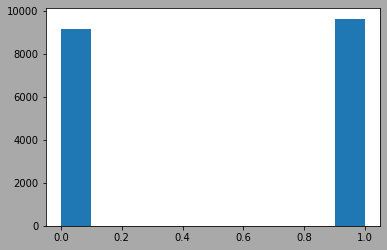

In [36]:
y = videos["trending"]
plt.hist(y)
x = videos.loc[:, videos.columns != "trending"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

x_train_stats = x_train.mean()

x_train = x_train.fillna(x_train_stats)
x_test = x_test.fillna(x_train_stats)

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")
x_train.head(5)

### Wybór miar oceny klasyfikatorów

Accuracy
TODO wyjaśnij wybór.

### Wybór pierwszego klasyfikatora

RandomForest
TODO uzasadnij wybór.

In [37]:
param_grid = {
    "reduce_dim__k": [5, 10, 20, 25, 30],  # range(1, 50, 5),
    "classifier__max_depth": [4, 8, 10],
    "classifier__min_samples_leaf": [1, 2],  # 2, 4],
    "classifier__n_estimators": [10, 50, 100, 200]

}

pipeline = Pipeline([
    ("reduce_dim", SelectKBest(chi2)),
    ("classifier", RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, n_jobs=8, param_grid=param_grid, cv=10, verbose=1, scoring="f1")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'reduce_dim__k': 30}



### Uczenie pierwszego klasyfikatora

In [38]:
k = grid_search.best_params_["reduce_dim__k"]
max_depth = grid_search.best_params_["classifier__max_depth"]
min_samples_leaf = grid_search.best_params_["classifier__min_samples_leaf"]
n_estimators = grid_search.best_params_["classifier__n_estimators"]
# Tree on Random Forest
select = SelectKBest(chi2, k=k)

x_train_selected = select.fit_transform(x_train, y_train)
x_test_selected = select.transform(x_test)

mask = select.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
rf.fit(x_train_selected, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200)

### Testowanie pierwszego klasyfikatora

Train accuracy: 0.6692850485953934
Train precision: 0.6137120959680107
Train recall: 0.9570018186541959
Train F1: 0.7478428585930363

Test accuracy: 0.674653887113951
Test precision: 0.6182307433568786
Test recall: 0.9548051948051948
Test F1: 0.7505104124132299



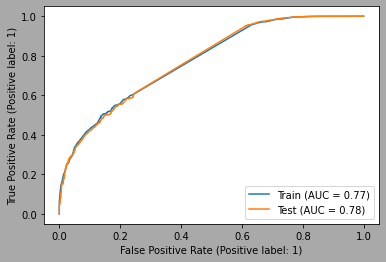

In [39]:
print_stats(rf, x_train_selected, y_train, x_test_selected, y_test)
rf_pred = lambda x: rf.predict_proba(x).astype(float)


### Interpretacja predykcji pierwszego klasyfikatora

Intercept -0.13605261039010286
Prediction_local [0.52137141]
Right: 0.5157481275784636


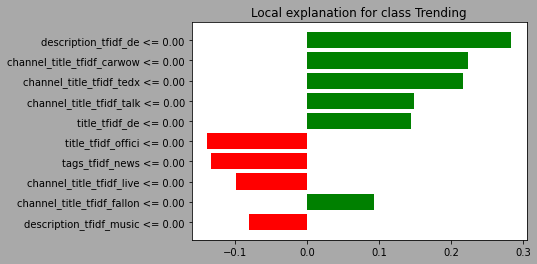

In [40]:
explainerRF = shap.TreeExplainer(rf)

shap_values_RF_test = explainerRF.shap_values(x_test_selected, approximate=True)
shap_values_RF_train = explainerRF.shap_values(x_train_selected, approximate=True)
# Random Forest
#TODO check index
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test[1], columns=x_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train[1], columns=x_train.columns.values)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train_selected.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], rf_pred)
exp.save_to_file("lime.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [41]:
j = 123
x_test_selected.loc[[j]]

title_tfidf_de  title_tfidf_en  title_tfidf_ft  title_tfidf_la  \
123             0.0             0.0             0.0             0.0   

     title_tfidf_music  title_tfidf_offici  title_tfidf_trailer  \
123                0.0                 0.0                  0.0   

     title_tfidf_video  channel_title_tfidf_bbc  channel_title_tfidf_carwow  \
123                0.0                      0.0                         0.0   

     ...  description_tfidf_music  tags_tfidf_anim  tags_tfidf_de  \
123  ...                      0.0              0.0            0.0   

     tags_tfidf_fallon  tags_tfidf_live  tags_tfidf_movi  tags_tfidf_music  \
123                0.0              0.0              0.0               0.0   

     tags_tfidf_new  tags_tfidf_news  tags_tfidf_trailer  
123             0.0              0.0                 0.0  

[1 rows x 30 columns]

In [42]:
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
print(y_test.to_numpy()[j])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP

shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


1
(2, 1, 30)


In [43]:
j = 2000
x_test_selected.loc[[j]]

title_tfidf_de  title_tfidf_en  title_tfidf_ft  title_tfidf_la  \
2000             0.0             0.0             0.0             0.0   

      title_tfidf_music  title_tfidf_offici  title_tfidf_trailer  \
2000                0.0                 0.0                  0.0   

      title_tfidf_video  channel_title_tfidf_bbc  channel_title_tfidf_carwow  \
2000                0.0                      0.0                         0.0   

      ...  description_tfidf_music  tags_tfidf_anim  tags_tfidf_de  \
2000  ...                      0.0              0.0            0.0   

      tags_tfidf_fallon  tags_tfidf_live  tags_tfidf_movi  tags_tfidf_music  \
2000                0.0              0.0              0.0               0.0   

      tags_tfidf_new  tags_tfidf_news  tags_tfidf_trailer  
2000             0.0              0.0                 0.0  

[1 rows x 30 columns]

In [44]:
print(y_test.to_numpy()[j])
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


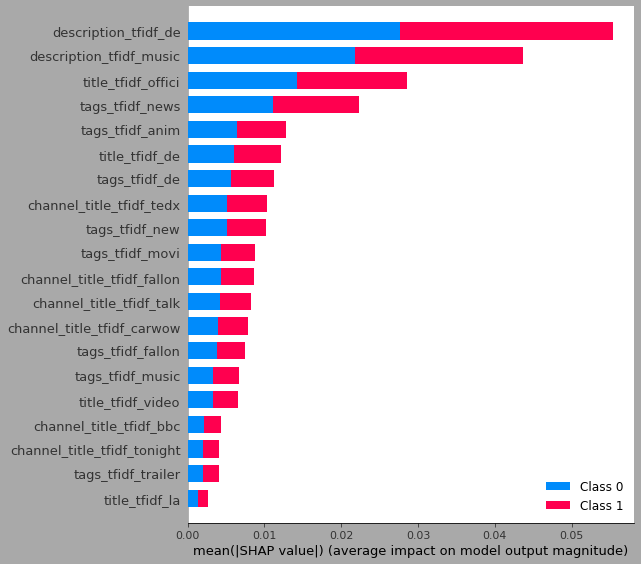

In [45]:
shap.summary_plot(shap_val, x_test_selected.loc[[j]])

### Interpretacja treningowych danych

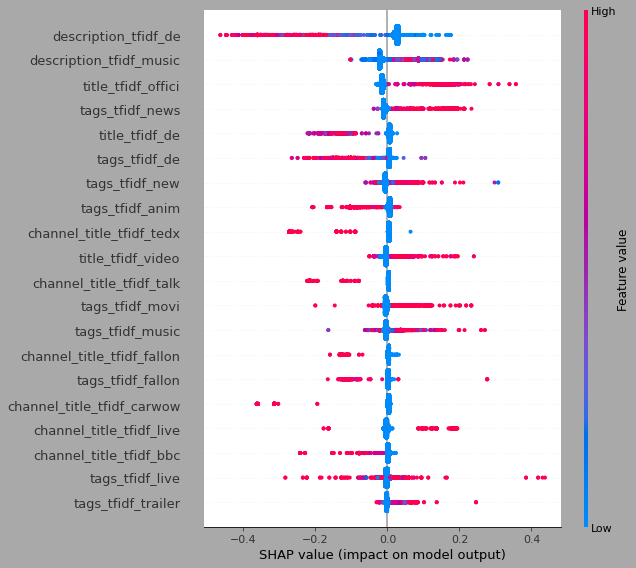

In [46]:
shap.summary_plot(shap_values_RF_train[1], x_train_selected)

### Interpretacja testowych danych

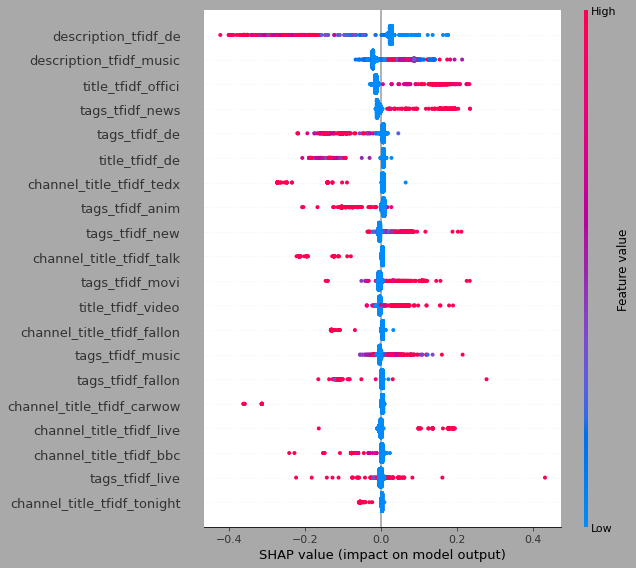

In [47]:
shap.summary_plot(shap_values_RF_test[1], x_test_selected)

# TODO pomyśl o filtrowaniu danych
# TODO pomyśl o odfiltrowaniu innych języków

### Wybór drugiego klasyfikatora

Jako drugi klasyfikator został wybrany XGBoost, ponieważ jest znany z tego że osiąga dobre wyniki (nawet na niezbalansowanych danych) jak i bardzo dobrze wyjaśnialny, poprzez to że w swojej mechanice ma zawarte ważności cech oraz prez zastosowanie boostingu oraz regularyzacji wewnątrz modelu.

### Testowanie klasyfikatora

In [48]:
xgbclf_base = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, verbosity=0)

print(xgbclf_base.fit(x_train, y_train))

y_pred = xgbclf_base.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)
              precision    recall  f1-score   support

    trending       0.89      0.93      0.91      1831
non-trending       0.93      0.89      0.91      1925

    accuracy                           0.91      3756
   macro avg       0.91      0.91      0.91      3756
weighted avg       0.91      0.91      0.91      3756



### Uczenie drugiego klasyfikatora

**Selekcja cech**

Selekcja cech została przeporwadzona poprzez analizę upadku trafności wraz z ograniczaniem liczby cech modelu

In [49]:
from sklearn.feature_selection import SelectFromModel

thresholds = sorted(xgbclf_base.feature_importances_)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)
selection_model.fit(x_train, y_train)
print("Base accuracy: %.2f%%" % (accuracy_score(y_test, selection_model.predict(x_test)) * 100))

for thresh in thresholds:
    selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)
    selection_model.fit(select_x_train, y_train)
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy * 100.0), accuracy)

Base accuracy: 78.01%
Thresh=0.000, n=77, Accuracy: 78.01% 0.7800851970181044
Thresh=0.000, n=77, Accuracy: 78.01% 0.7800851970181044
Thresh=0.000, n=77, Accuracy: 78.01% 0.7800851970181044
Thresh=0.000, n=77, Accuracy: 78.01% 0.7800851970181044
Thresh=0.002, n=73, Accuracy: 78.01% 0.7800851970181044
Thresh=0.002, n=72, Accuracy: 78.01% 0.7800851970181044
Thresh=0.003, n=71, Accuracy: 78.01% 0.7800851970181044
Thresh=0.003, n=70, Accuracy: 78.01% 0.7800851970181044
Thresh=0.003, n=69, Accuracy: 78.01% 0.7800851970181044
Thresh=0.004, n=68, Accuracy: 78.17% 0.7816826411075612
Thresh=0.004, n=67, Accuracy: 78.17% 0.7816826411075612
Thresh=0.004, n=66, Accuracy: 78.22% 0.7822151224707136
Thresh=0.004, n=65, Accuracy: 78.22% 0.7822151224707136
Thresh=0.004, n=64, Accuracy: 77.72% 0.7771565495207667
Thresh=0.005, n=63, Accuracy: 78.14% 0.781416400425985
Thresh=0.005, n=62, Accuracy: 78.14% 0.781416400425985
Thresh=0.006, n=61, Accuracy: 78.14% 0.781416400425985
Thresh=0.006, n=60, Accuracy:

Jak rozsądną wartość ilość cech została ograniczona do 56

### Interpretacja predykcji

In [50]:
thresh = thresholds[-58]
selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
x_train_selected = selection.transform(x_train)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbose=0)
selection_model.fit(x_train_selected, y_train)

x_test_selected = selection.transform(x_test)
y_pred = selection_model.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, x_train_selected.shape[1], accuracy * 100.0))

mask = selection.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

Thresh=0.006, n=58, Accuracy: 78.35%


**Strojenie parametrów**

Strojenie odbywa się na modelu o mniejszej ilości estymatorów (ze względu na czas obliczeń)

In [51]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 2, 5],
    'max_depth': [3, 6, 9, 15]
}
xgbclf_par = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, nthread=1, verbosity=0)
grid_search = GridSearchCV(xgbclf_par, n_jobs=8, param_grid=params, cv=3, verbose=1)
grid_search.fit(x_train_selected, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'gamma': 0, 'max_depth': 15, 'min_child_weight': 1}


In [52]:
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_score_)

[0.72273962 0.72506926 0.72753276 0.77546271 0.76714074 0.75635733
 0.80615087 0.78930905 0.78398351 0.82738672 0.81460521 0.80155755
 0.7245371  0.72506926 0.72700017 0.76507779 0.7647444  0.75748866
 0.79896121 0.79077385 0.78012207 0.82652093 0.8074818  0.79603216
 0.72440397 0.72506926 0.72486993 0.77053632 0.76467779 0.75243014
 0.79296999 0.7817867  0.78225252 0.81893166 0.80528513 0.7947675 ]
0.8273867198275981


### Uczenie drugiego klasyfikatora

In [53]:
min_child_weight = grid_search.best_params_["min_child_weight"]
max_depth = grid_search.best_params_["max_depth"]
gamma = grid_search.best_params_["gamma"]

xgbclf = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, nthread=-1, verbosity=0,
                           objective='binary:logistic',
                           min_child_weight=min_child_weight,
                           max_depth=max_depth,
                           gamma=gamma)

xgbclf.fit(x_train_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

Train accuracy: 0.9999334309679138
Train precision: 1.0
Train recall: 0.9998700961288647
Train F1: 0.9999350438454043

Test accuracy: 0.9065495207667732
Test precision: 0.9328932893289329
Test recall: 0.8810389610389611
Test F1: 0.9062249532460593



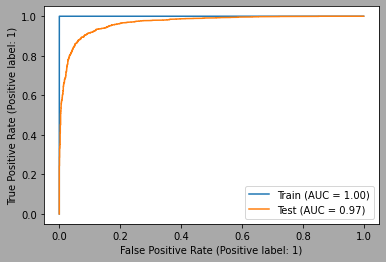

Test results: 
               precision    recall  f1-score   support

    trending       0.88      0.93      0.91      1831
non-trending       0.93      0.88      0.91      1925

    accuracy                           0.91      3756
   macro avg       0.91      0.91      0.91      3756
weighted avg       0.91      0.91      0.91      3756



In [54]:
print_stats(xgbclf, x_train_selected, y_train, x_test_selected, y_test)
y_pred = xgbclf.predict(x_test_selected)
print("Test results: \n", classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

Ważność atrybutów wg. weight pokazuje jak często w drzewach pojawiają się dane cechy

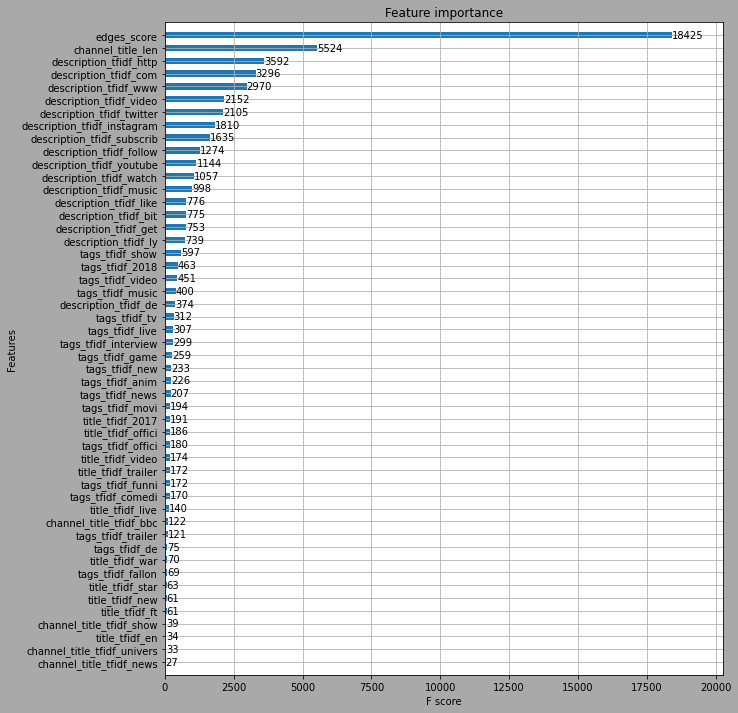

In [55]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='weight')
plt.show()

Ważność atrybutów wg. gain ozancza jak dużą część trafności wnosi dana cecha

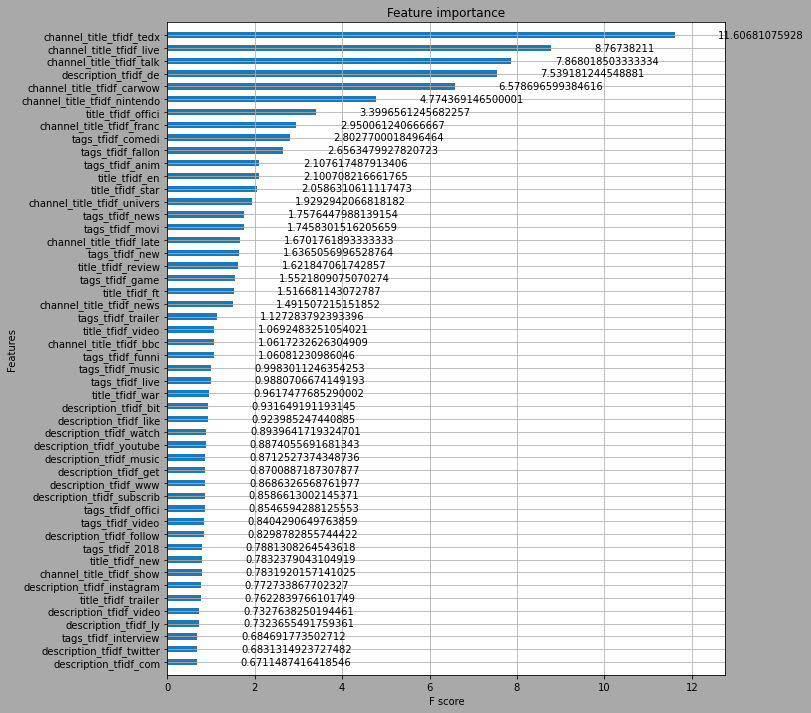

In [56]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='gain')
plt.show()

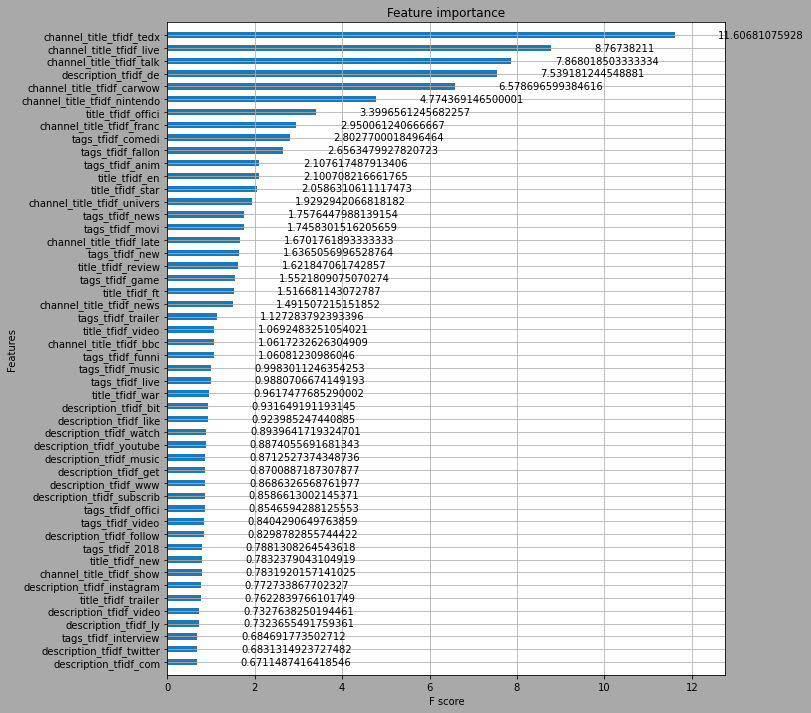

In [57]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='gain')
plt.show()

In [58]:
xgbclf_base = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbosity=0)

print(xgbclf_base.fit(x_train, y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)


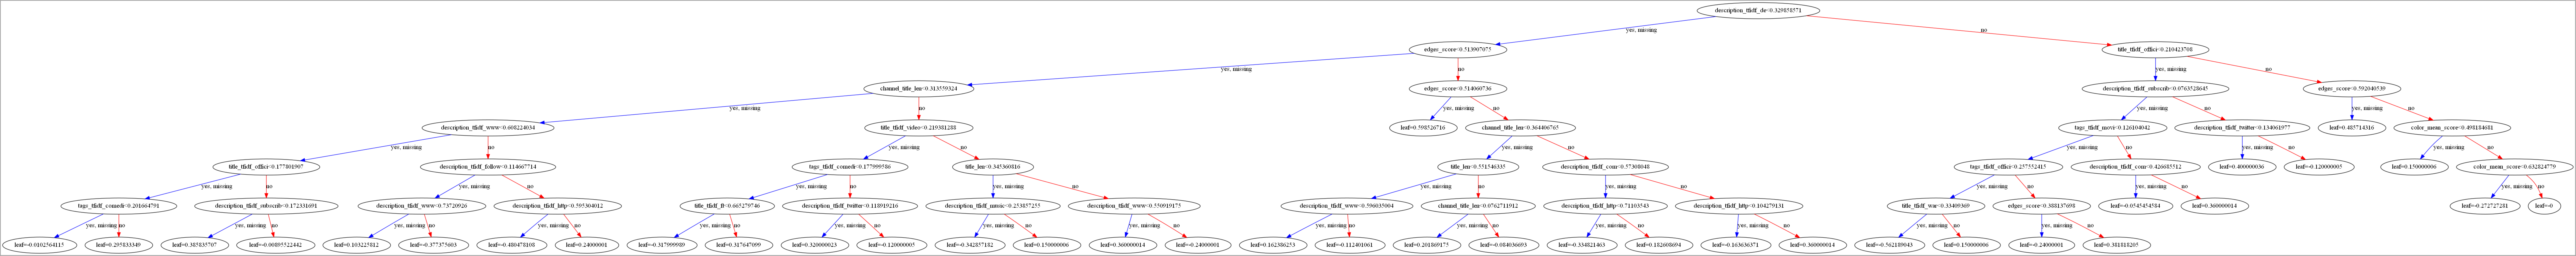

In [59]:
plt.rcParams['figure.figsize'] =  [400, 400]
a = xgb.plot_tree(xgbclf_base,num_trees=0)
plt.show()

# fig = plt.gcf()
# fig.set_size_inches(1000, 500)
# fig.show()

### SHAP

Intercept 0.11616470957296998
Prediction_local [0.63578933]
Right: 0.9686356782913208


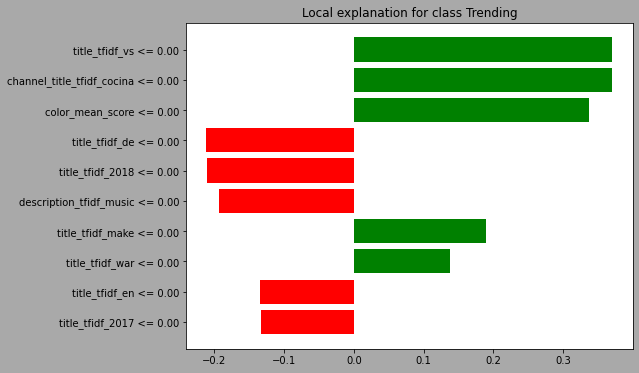

In [60]:
plt.rcParams['figure.figsize'] = [8, 6]
xgb_pred = lambda x: xgbclf.predict_proba(x).astype(float)

# LIME has one explainer for all models,

explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], xgb_pred)
exp.save_to_file("lime2.html")
# exp.show_in_notebook(show_table=True),
fig = exp.as_pyplot_figure()
plt.show(fig)

In [61]:
x_sampled = x_test_selected.sample(100, random_state=0)
explainerXgb = shap.TreeExplainer(xgbclf)
shap_values = explainerXgb.shap_values(x_sampled)

In [62]:
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_sampled.iloc[1])

In [63]:
shap_values = explainerXgb.shap_values(x_train_selected)
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_train_selected.iloc[1])

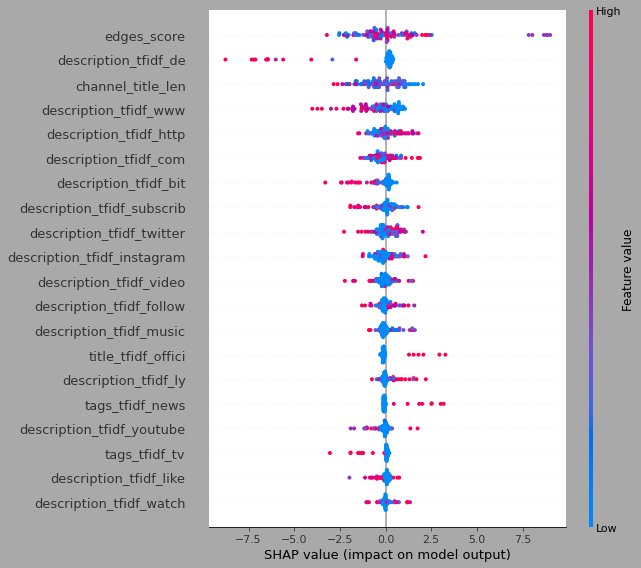

In [64]:
shap_values = explainerXgb.shap_values(x_sampled)
shap.summary_plot(shap_values, x_sampled)

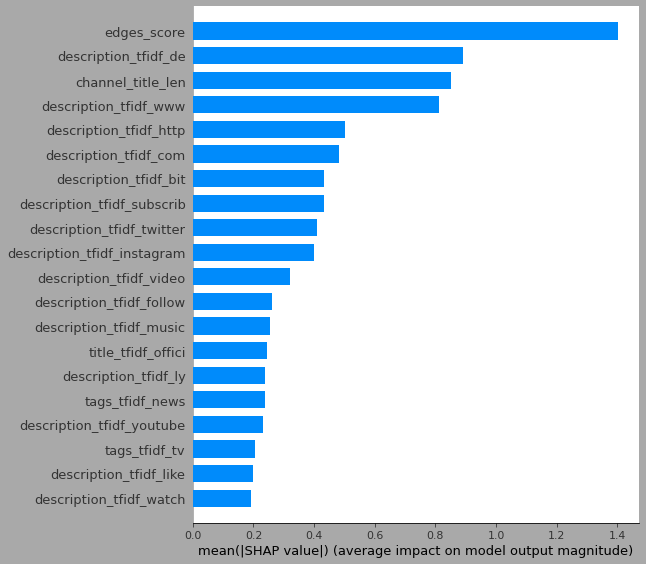

In [65]:
shap.summary_plot(shap_values, x_sampled, plot_type="bar")